## Classifier Performance Summary
#### Plot to summarise the performance of the different classifiers on BOSS DR12 data
In this notebook, we load the results from all of our classifiers on a subset of the BOSS DR12Q Superset, and compare the results. We look at performance vs redshift, R-band magnitude, and signal-to-noise ratio.

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import fitsio
from astropy.io import fits
from astropy.table import Table, join
from keras.models import load_model
from quasarnet.io import read_data
from quasarnet.utils import process_preds, absorber_IGM, Wave
%matplotlib inline

from quasarnet.notebook_utils import *

from utils import *

Using TensorFlow backend.


In [2]:
qnet_path = '/global/homes/j/jfarr/Projects/QuasarNET/'
figsize = (12,6.5)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
## RR parameters

## QN parameters
n_lines = 1
c_th = 0.8
include_cmax_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [4]:
f_truth = qnet_path+'/data/truth_DR12Q.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

## Load the VI data.
#f_sdrq = '/global/projecta/projectdirs/sdss/staging/dr12/boss/qso/DR12Q/Superset_DR12Q.fits'
#data['VI'] = load_sdrq_data(f_sdrq)

## Load the RR data.
f_rr = '../results/rr_results/rr_sdr12q.fits'
data['RR'] = load_rr_data(f_rr)

## Load the DR12 pipeline data.
f_dr12pipe = '../results/dr12pipe_results/dr12pipe_sdr12q.fits'
data['PIPE'] = load_rr_data(f_dr12pipe)

## Load the QN data.
f_qn = '../results/qn_results/qn_performance_vs_training_set_size/qn_90pc.fits'
data['QN'] = load_qn_data(f_qn,n_lines=n_lines,c_th=c_th,include_cmax=include_cmax_qn)

## Load the SQ data.
f_sq = '../results/sq_results/sq_sdr12q.fits'
data['SQ'] = load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)

### Find the set of common targetids, and reduce all data to that set
This finds which targetids* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each targetid, and produces a single data table.

\* targetid = plate$\times$1000000000 + mjd$\times$10000 + fiber

In [6]:
data_table = reduce_data_to_table(data,truth,include_cmax_qn=include_cmax_qn,include_p_sq=include_p_sq)
data_table[:5]

INFO: 61729 common targetids


THING_ID,TARGETID,PLATE,MJD,FIBERID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR,Z_PIPE,Z_QN,Z_SQ,CLASS_RR,CLASS_PIPE,CLASS_QN,CLASS_SQ,ISQSO_RR,ISQSO_PIPE,ISQSO_QN,ISQSO_SQ,CMAX_QN,P_SQ,ZWARN_RR,ZWARN_PIPE
int64,int64,int64,int64,int64,int64,float64,str8,bool,float64,float64,float64,float64,str8,str8,str8,str8,bool,bool,bool,bool,float64,float64,int64,int64
77823481,3586551810050,3586,55181,50,2,0.000,STAR,False,-0.000,-0.000,2.039,0.535,STAR,STAR,NONQSO,NONQSO,False,False,False,False,0.000,0.144,0,0
75657603,3586551810414,3586,55181,414,2,0.000,STAR,False,0.000,0.000,2.057,0.544,STAR,STAR,NONQSO,NONQSO,False,False,False,False,0.000,0.316,0,0
96887043,3586551810500,3586,55181,500,2,0.000,STAR,False,-0.000,-0.000,2.022,0.913,STAR,STAR,NONQSO,NONQSO,False,False,False,False,0.000,0.209,0,0
106776674,3586551810510,3586,55181,510,2,0.000,STAR,False,1.532,5.725,1.515,-1.000,GALAXY,QSO,NONQSO,NONQSO,False,True,False,False,0.005,-1.000,0,4
104298275,3586551810514,3586,55181,514,1,2.100,QSO,True,1.112,1.111,1.106,0.740,QSO,QSO,QSO,NONQSO,True,True,True,False,0.998,0.279,0,4


In [7]:
# Include only objects in the data table that have the highest confidence level.
data_table = data_table[data_table['ZCONF_PERSON']==2]
len(data_table)

60375

### Compare the performance of the classifiers.
We would like to show the performance of the different classifiers on a single dataset. We can show purity and completeness vs a range of different quantities.

In [8]:
ls = {'RR': '-',
      'QN': '--',
      'SQ': ':',
      'PIPE': '-.',
     }
cs = {'RR': colours['C0'],
      'QN': colours['C1'],
      'SQ': colours['C2'],
      'PIPE': colours['C3'],
     }
legend_name = {'RR': 'redrock',
               'QN': 'QuasarNET',
               'SQ': 'SQUEzE',
               'PIPE': 'DR12 Pipeline',
              }

#### Performance vs redshift

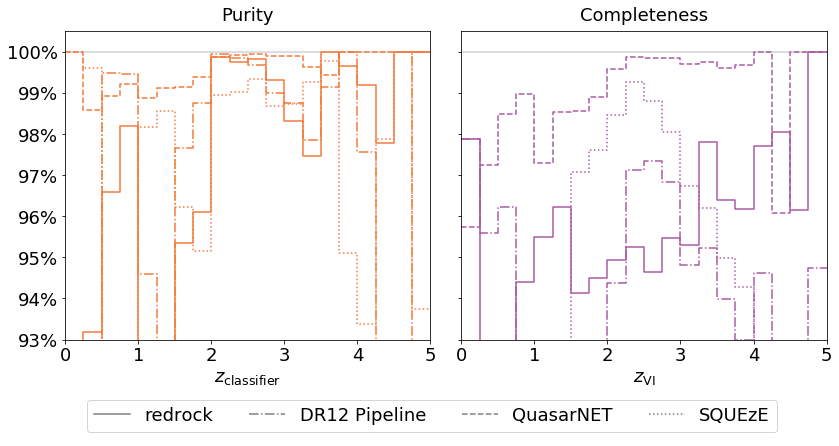

In [17]:
fig, axs = plt.subplots(1,2,figsize=(figsize[0],figsize[1]),sharey=True)
cth = 0.8
pmin = 0.32

dv_max = 6000. #km/s
z_min = 0.
z_max = 5.
dz_int = 21

dz_edges = np.linspace(z_min,z_max,dz_int)
dz_mids = (dz_edges[1:] + dz_edges[:-1])/2.
dz_widths = (dz_edges[1:] - dz_edges[:-1])

isqso_truth = (data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2))
isgal_truth = (data_table['CLASS_VI']=='GALAXY')
isbad = ((data_table['CLASS_VI']=='BAD') | (data_table['ZCONF_PERSON']!=2))

for j,c in enumerate(data.keys()):
    com = []
    pur = []
    
    if c=='QN':
        isqso_c = (data_table['CMAX_{}'.format(c)]>cth)
    elif c=='SQ':
        isqso_c = (data_table['P_{}'.format(c)]>pmin)
    else:
        isqso_c = (data_table['ISQSO_{}'.format(c)]) & (data_table['ZWARN_{}'.format(c)]==0)

    z_c = data_table['Z_{}'.format(c)]
    zgood = (data_table['Z_VI']>0) & (abs(z_c-data_table['Z_VI']) < dv_max*(1+data_table['Z_VI'])/300000.)
    
    for i in range(len(dz_edges)-1):
        
        in_zbin_zvi = (data_table['Z_VI']>=dz_edges[i]) & (data_table['Z_VI']<dz_edges[i+1])
        in_zbin_zc = (z_c>=dz_edges[i]) & (z_c<dz_edges[i+1])
        
        pur_num = (isqso_c & (isqso_truth | isgal_truth) & zgood & ~isbad & in_zbin_zc).sum()
        pur_denom = (isqso_c & (~isbad) & in_zbin_zc).sum()
        
        com_num = (isqso_c & zgood & isqso_truth & in_zbin_zvi).sum()
        com_denom = (isqso_truth & in_zbin_zvi).sum()
        
        pur += [pur_num/pur_denom]
        com += [com_num/com_denom]

    axs[0].step(dz_edges,[pur[0]]+pur,where='pre',label=c,color=colours['C0'],ls=ls[c])
    #axs[0].scatter(dz_mids,pur,color=colours['C0'],marker='x')
    axs[1].step(dz_edges,[com[0]]+com,where='pre',label=c,color=colours['C1'],ls=ls[c])
    #axs[1].scatter(dz_mids,com,color=colours['C1'],marker='x')

for ax in axs:
    ax.set_xlim(0.,5.)
    ax.set_ylim(0.93,1.005)
    ax.axhline(y=1.0,c='lightgrey',zorder=-1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))

axs[0].set_xlabel(r'$z_\mathrm{classifier}$')
axs[1].set_xlabel(r'$z_\mathrm{VI}$')

axs[0].text(0.5,1.05,'Purity',ha='center',va='center',
              transform=axs[0].transAxes,rotation=0)
axs[1].text(0.5,1.05,'Completeness',ha='center',va='center',
              transform=axs[1].transAxes,rotation=0)

artists = []
labels = []
for j,c in enumerate(data.keys()):
    artists += [axs[0].step([0],[0],where='pre',color='grey',ls=ls[c])[0]]
    labels += [legend_name[c]]

fig.legend(artists,labels,loc='lower center',borderaxespad=0,bbox_to_anchor=(0.5,0.03),ncol=len(artists))
rect = (0,0.1,1,1.0)
plt.tight_layout(rect=rect)
#plt.margins(x=0.1,y=0.1)

plt.savefig('../plots/classifier_performance_summary.pdf')
plt.show()

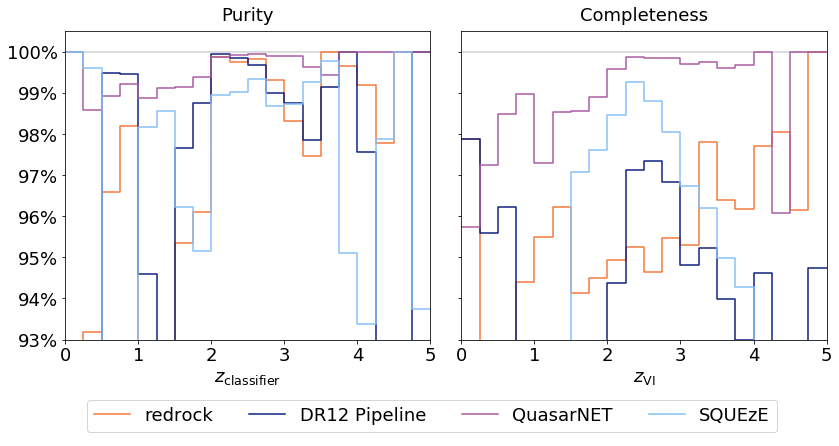

In [16]:
## Same plot as above but colouring classifiers differently

fig, axs = plt.subplots(1,2,figsize=(figsize[0],figsize[1]),sharey=True)
cth = 0.8
pmin = 0.32

dv_max = 6000. #km/s
z_min = 0.
z_max = 5.
dz_int = 21

dz_edges = np.linspace(z_min,z_max,dz_int)
dz_mids = (dz_edges[1:] + dz_edges[:-1])/2.
dz_widths = (dz_edges[1:] - dz_edges[:-1])

isqso_truth = (data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2))
isgal_truth = (data_table['CLASS_VI']=='GALAXY')
isbad = ((data_table['CLASS_VI']=='BAD') | (data_table['ZCONF_PERSON']!=2))

for j,c in enumerate(data.keys()):
    com = []
    pur = []
    
    if c=='QN':
        isqso_c = (data_table['CMAX_{}'.format(c)]>cth)
    elif c=='SQ':
        isqso_c = (data_table['P_{}'.format(c)]>pmin)
    else:
        isqso_c = (data_table['ISQSO_{}'.format(c)]) & (data_table['ZWARN_{}'.format(c)]==0)

    z_c = data_table['Z_{}'.format(c)]
    zgood = (data_table['Z_VI']>0) & (abs(z_c-data_table['Z_VI']) < dv_max*(1+data_table['Z_VI'])/300000.)
    
    for i in range(len(dz_edges)-1):
        
        in_zbin_zvi = (data_table['Z_VI']>=dz_edges[i]) & (data_table['Z_VI']<dz_edges[i+1])
        in_zbin_zc = (z_c>=dz_edges[i]) & (z_c<dz_edges[i+1])
        
        pur_num = (isqso_c & (isqso_truth | isgal_truth) & zgood & ~isbad & in_zbin_zc).sum()
        pur_denom = (isqso_c & (~isbad) & in_zbin_zc).sum()
        
        com_num = (isqso_c & zgood & isqso_truth & in_zbin_zvi).sum()
        com_denom = (isqso_truth & in_zbin_zvi).sum()
        
        pur += [pur_num/pur_denom]
        com += [com_num/com_denom]

    axs[0].step(dz_edges,[pur[0]]+pur,where='pre',label=c,color=cs[c])
    #axs[0].scatter(dz_mids,pur,color=colours['C0'],marker='x')
    axs[1].step(dz_edges,[com[0]]+com,where='pre',label=c,color=cs[c])
    #axs[1].scatter(dz_mids,com,color=colours['C1'],marker='x')

for ax in axs:
    ax.set_xlim(0.,5.)
    ax.set_ylim(0.93,1.005)
    ax.axhline(y=1.0,c='lightgrey',zorder=-1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))

axs[0].set_xlabel(r'$z_\mathrm{classifier}$')
axs[1].set_xlabel(r'$z_\mathrm{VI}$')

axs[0].text(0.5,1.05,'Purity',ha='center',va='center',
              transform=axs[0].transAxes,rotation=0)
axs[1].text(0.5,1.05,'Completeness',ha='center',va='center',
              transform=axs[1].transAxes,rotation=0)

artists = []
labels = []
for j,c in enumerate(data.keys()):
    artists += [axs[0].step([0],[0],where='pre',color=cs[c])[0]]
    labels += [legend_name[c]]

fig.legend(artists,labels,loc='lower center',borderaxespad=0,bbox_to_anchor=(0.5,0.03),ncol=len(artists))
rect = (0.0,0.1,1.0,1.0)
plt.tight_layout(rect=rect)
#plt.margins(x=0.1,y=0.1)

plt.savefig('../plots/classifier_performance_summary_altcolour.pdf')
plt.show()

### Performance vs c_th in two redshift bins

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


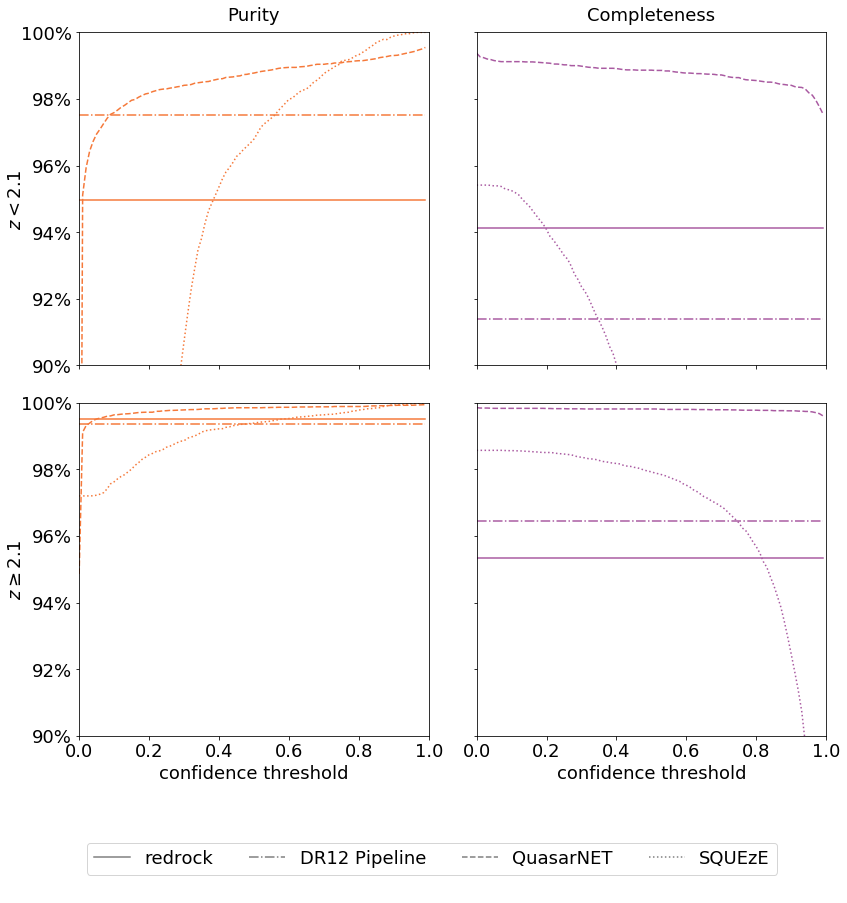

In [18]:
fig, axs = plt.subplots(2,2,figsize=(figsize[0],2*figsize[1]),sharex=True,sharey=True)

zlya = 2.1

cth_min = 0.0
cth_max = 1.0
n_int = 100
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))
ndetect = 1

isqso_truth = (data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2))
isgal_truth = (data_table['CLASS_VI']=='GALAXY')
isbad = ((data_table['ZCONF_PERSON']=='BAD') | (data_table['ZCONF_PERSON']!=2))
zbins = [(-10.,2.1),(2.1,10.)]

for j,c in enumerate(data.keys()):

    for i,zbin in enumerate(zbins):
    
        z_c = data_table['Z_{}'.format(c)]
        in_zbin_zvi = (data_table['Z_VI']>=zbin[0]) & (data_table['Z_VI']<zbin[1])
        in_zbin_zc = (z_c>=zbin[0]) & (z_c<zbin[1])

        com = []
        pur = []
    
        z_c = data_table['Z_{}'.format(c)]
        zgood = (data_table['Z_VI']>-1) & (abs(z_c-data_table['Z_VI']) < dv_max*(1+data_table['Z_VI'])/300000.)

        for cth in c_th:
            if c=='QN':
                isqso_c = (data_table['CMAX_{}'.format(c)]>cth)>=ndetect
            elif c=='SQ':
                isqso_c = (data_table['P_{}'.format(c)]>cth)
            else:
                isqso_c = (data_table['ISQSO_{}'.format(c)]) & (data_table['ZWARN_{}'.format(c)]==0)

            pur_num = (isqso_c & (isqso_truth | isgal_truth) & zgood & ~isbad & in_zbin_zc).sum()
            pur_denom = (isqso_c & (~isbad) & in_zbin_zc).sum()

            com_num = (isqso_c & zgood & isqso_truth & in_zbin_zvi).sum()
            com_denom = (isqso_truth & in_zbin_zvi).sum()

            pur += [pur_num/pur_denom]
            com += [com_num/com_denom]

        axs[i,0].plot(c_th,pur,color=colours['C0'],ls=ls[c])
        axs[i,1].plot(c_th,com,color=colours['C1'],ls=ls[c])

axs[0,0].text(-0.18,0.5,r'$z<2.1$',ha='center',va='center',
              transform=axs[0,0].transAxes,rotation=90)
axs[1,0].text(-0.18,0.5,r'$z\geq2.1$',ha='center',va='center',
              transform=axs[1,0].transAxes,rotation=90)
axs[0,0].text(0.5,1.05,'Purity',ha='center',va='center',
              transform=axs[0,0].transAxes,rotation=0)
axs[0,1].text(0.5,1.05,'Completeness',ha='center',va='center',
              transform=axs[0,1].transAxes,rotation=0)

for ax in axs[0,:]:
    ax.set_xlim(0.,1.)
    ax.set_ylim(0.9,1.0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
for ax in axs[1,:]:
    ax.set_xlabel(r'confidence threshold')
    ax.set_xlim(0.,1.)
    ax.set_ylim(0.9,1.0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))

artists = []
labels = []
for j,c in enumerate(data.keys()):
    artists += [axs[0,0].step([0],[0],where='pre',color='grey',ls=ls[c])[0]]
    labels += [legend_name[c]]

fig.legend(artists,labels,loc='lower center',borderaxespad=0,bbox_to_anchor=(0.5,0.03),ncol=len(artists))
rect = (0,0.13,1.,1.)
plt.tight_layout(rect=rect)
#plt.margins(x=0.1,y=0.1)

plt.savefig('../plots/classifier_performance_summary_alt.pdf')
plt.show()

/global/homes/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


1044 25700
238 1


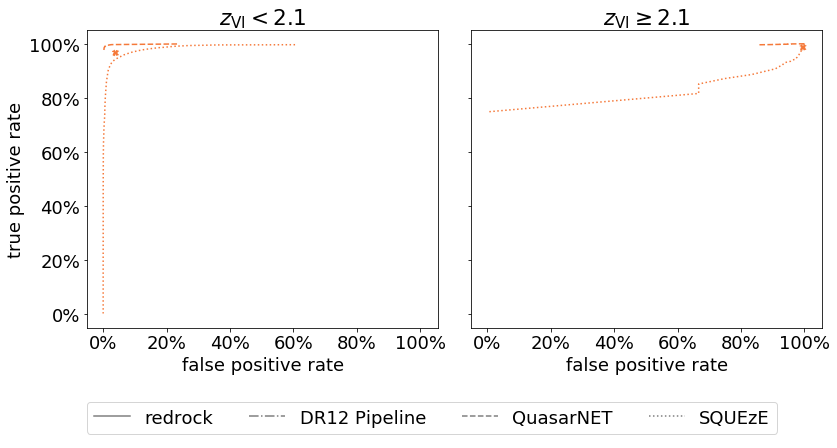

In [13]:
fig, axs = plt.subplots(1,2,figsize=(figsize[0],figsize[1]),sharex=True,sharey=True)

zlya = 2.1

cth_min = 0.0
cth_max = 1.0
n_int = 100
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))
ndetect = 1

isqso_truth = (data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2))
isgal_truth = (data_table['CLASS_VI']=='GALAXY')
isbad = ((data_table['ZCONF_PERSON']=='BAD') | (data_table['ZCONF_PERSON']!=2))
islya = (data_table['Z_VI']>=zlya)

for j,c in enumerate([k for k in data.keys() if k!='RR']):

    for i,wz in enumerate([~islya,islya]):
    
        tpr = []
        fpr = []
    
        z_c = data_table['Z_{}'.format(c)]
        zgood = (data_table['Z_VI']>-1) & (abs(z_c-data_table['Z_VI']) < dv_max*(1+data_table['Z_VI'])/300000.)

        for cth in c_th:
            if c=='QN':
                isqso_c = (data_table['CMAX_{}'.format(c)]>cth)>=ndetect
            elif c=='SQ':
                isqso_c = (data_table['P_{}'.format(c)]>cth)
            elif c=='RR':
                isqso_c = (data_table['ISQSO_{}'.format(c)])

            tp = (isqso_c & (isqso_truth | isgal_truth) & zgood & ~isbad & wz).sum()
            fp = (isqso_c & (~isbad) & wz).sum() - tp
            tn = (~isqso_c & (~isqso_truth) & wz).sum()
            fn = (~isqso_c & isqso_truth & wz).sum()
            
            tpr += [tp/(tp+fn)]
            fpr += [fp/(tn+fp)]
                   
        axs[i].plot(fpr,tpr,color=colours['C0'],ls=ls[c])

for i,wz in enumerate([~islya,islya]):
    isqso_rr = data_table['ISQSO_RR']
    tp = (isqso_rr & (isqso_truth | isgal_truth) & zgood & ~isbad & wz).sum()
    fp = (isqso_rr & (~isbad) & wz).sum() - tp
    tn = (~isqso_rr & (~isqso_truth) & wz).sum()
    fn = (~isqso_rr & isqso_truth & wz).sum()
    tpr = [tp/(tp+fn)]
    fpr = [fp/(tn+fp)]
    print(fp,tn)
    axs[i].scatter(fpr,tpr,color=colours['C0'],ls=ls[c],marker='X')

axs[0].set_title(r'$z_\mathrm{VI}<2.1$')
axs[1].set_title(r'$z_\mathrm{VI}\geq2.1$')

for ax in axs:
    #ax.set_xlim(0.,1.)
    #ax.set_ylim(0.,1.)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
    ax.set_xlabel(r'false positive rate')

axs[0].set_ylabel(r'true positive rate')

artists = []
labels = []
for j,c in enumerate(data.keys()):
    artists += [axs[0].step([0],[0],where='pre',color='grey',ls=ls[c])[0]]
    labels += [legend_name[c]]

fig.legend(artists,labels,loc='lower center',borderaxespad=0,bbox_to_anchor=(0.5,0.03),ncol=len(artists))
rect = (0,0.13,1.,1.)
plt.tight_layout(rect=rect)
#plt.margins(x=0.1,y=0.1)

plt.savefig('../plots/classifier_performance_summary_alt2.pdf')
plt.show()